In [17]:
import os
import cv2
import numpy as np
import urllib
import matplotlib.pyplot as plt
from skimage import io
import requests
from bs4 import BeautifulSoup
%matplotlib inline

# Токен vk.api

In [18]:
token = ''

# Настройки работы

In [19]:
# id пользователя
main_user = 92064250
# количество фотографий для обработки. 0 = все 
pics_to_load = 0

# Запрос фотографии

In [20]:
data = requests.get(f'https://api.vk.com/method/photos.get?owner_id={main_user}&album_id=profile&v=5.131&access_token={token}')
data = data.json()
profile_is_closed = False
if not data.get('error'):
    count_of_pics = len(data['response']['items'])
    count_of_pics
else:
    print('Вероятно закрытый профиль')
    profile_is_closed = True

In [21]:
if not profile_is_closed:
    if pics_to_load == 0:
        pics_to_load = count_of_pics
    pics = np.arange((pics_to_load), dtype='object')
    for i, pic in enumerate(data['response']['items']):
        pics[i] = pic['sizes'][-1]['url']

# pics[1]

# Create config file from frozen graph

1. Extract the files 
2. Run the [tf_text_graph_ssd.py](https://github.com/opencv/opencv/blob/master/samples/dnn/tf_text_graph_ssd.py) file with input as the path to the frozen_graph.pb file and output as desired.



**A sample config file has been included in the models folder**

In [22]:
modelFile = "models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
configFile = "models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt"
classFile = "coco_class_labels.txt"

if not os.path.isdir('models'):
    os.mkdir("models")

if not os.path.isfile(modelFile):
    os.chdir("models")
    # Download the tensorflow Model
    urllib.request.urlretrieve('http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz', 'ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Uncompress the file
    !tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

    # Delete the tar.gz file
    os.remove('ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Come back to the previous directory
    os.chdir("..")

# Check Class Labels 


In [23]:
with open(classFile) as fp:
    labels = fp.read().split("\n")
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


In [24]:
objects_score = dict.fromkeys(labels,0)

**The steps for performing infernece using a DNN model are summarized below:**
    
1. Load the model and input image into memory.
2. Detect objects using a forward pass through the network.
3. Display the detected objects with bounding boxes and class labels.

# Read Tensorflow Model

In [25]:
# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

# Detect Objects


In [26]:
# For ach file in the directory
def detect_objects(net, im):
    dim = 300
    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(im, 1.0, size=(dim, dim), mean=(0,0,0), swapRB=False, crop=False)

    # Pass blob to the network
    net.setInput(blob)
            
    # Peform Prediction
    objects = net.forward()
    return objects


In [27]:
def display_text(im, text, x, y):
    # Get text size 
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
                    
    # Use text size to create a black rectangle    
    cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED)
    # Display text inside the rectangle
    cv2.putText(im, text, (x, y-5 ), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)


# Display Objects

In [28]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_objects(im, objects, threshold = 0.25):

    rows = im.shape[0]; cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence 
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])
        
        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)
        
        # Check if the detection is of good quality
        if score > threshold:
            display_text(im, "{}".format(labels[classId]), x, y)
            objects_score[labels[classId]] += 1
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
    # Convert Image to RGB since we are using Matplotlib for displaying image
    # mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # plt.figure(figsize=(30,10)); plt.imshow(im); plt.show()
    plt.subplot(132),plt.imshow(im),  plt.title("After")
    plt.show()

# Results

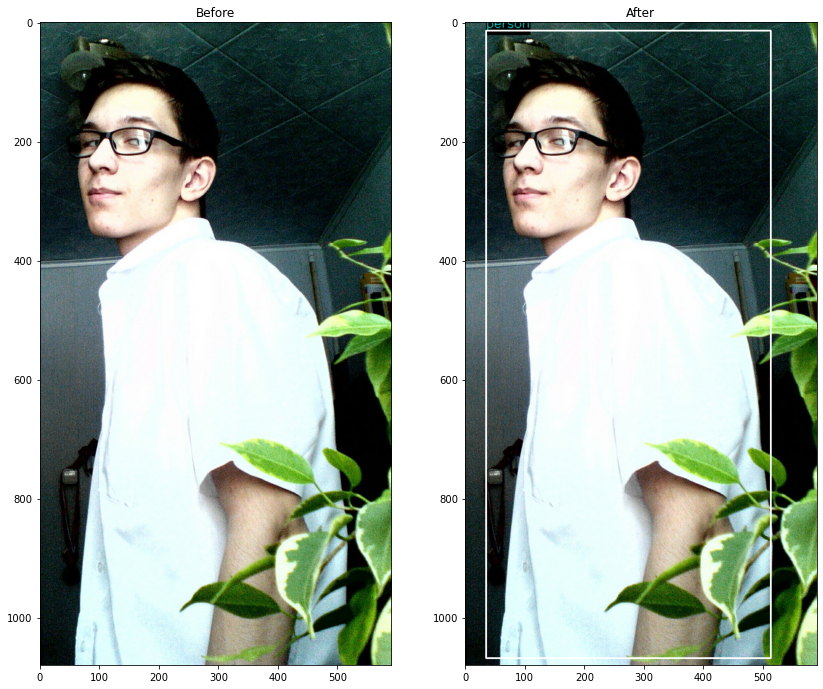

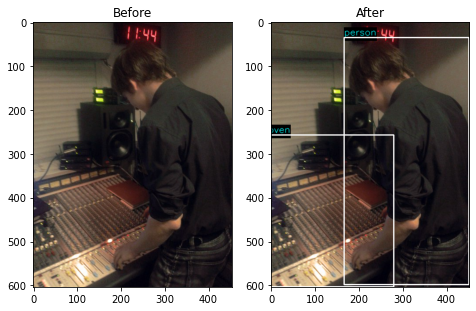

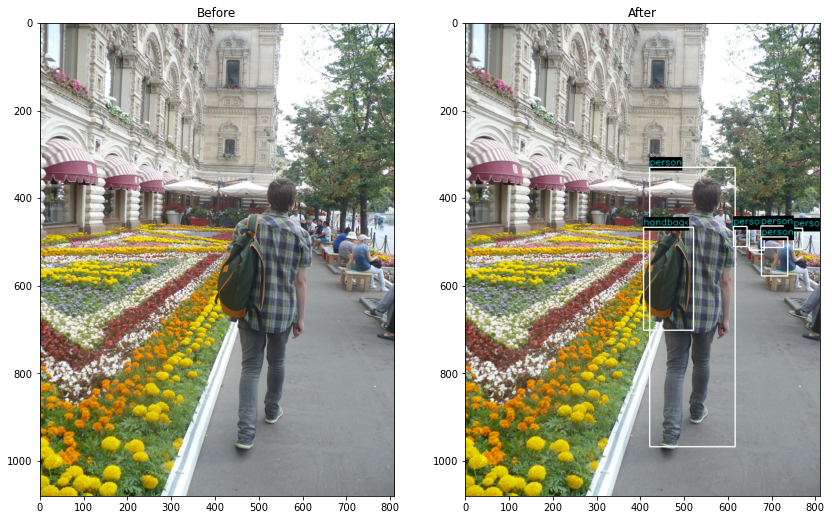

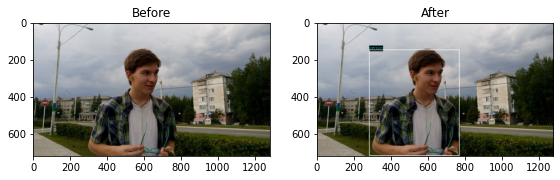

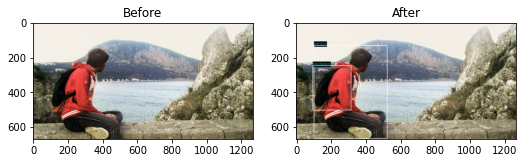

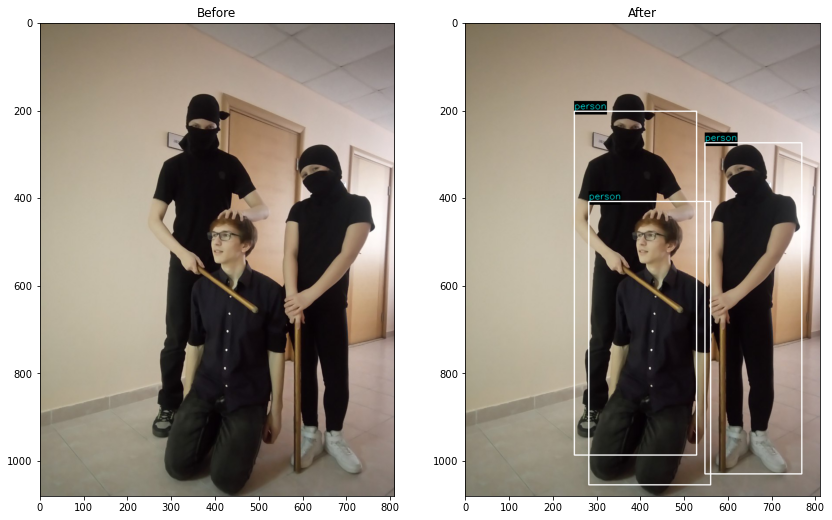

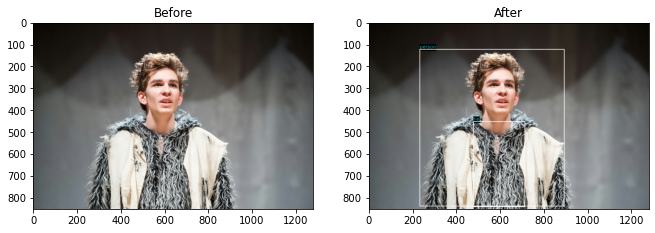

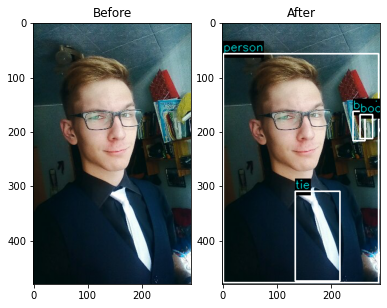

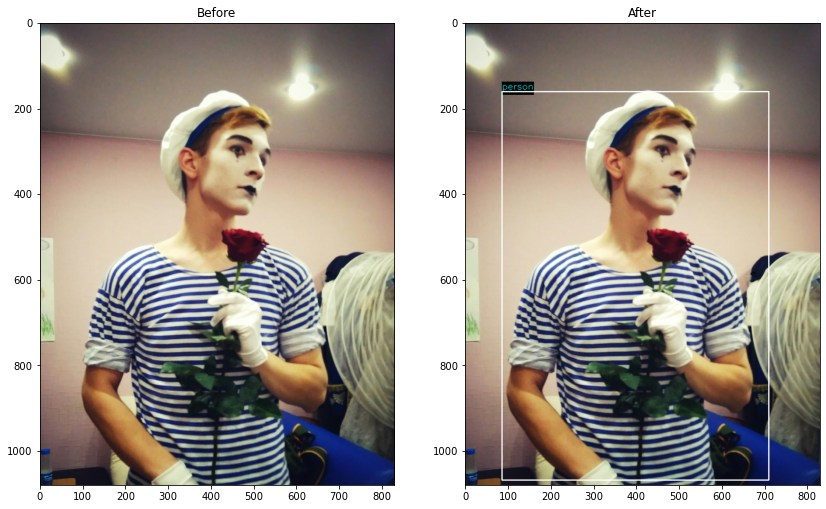

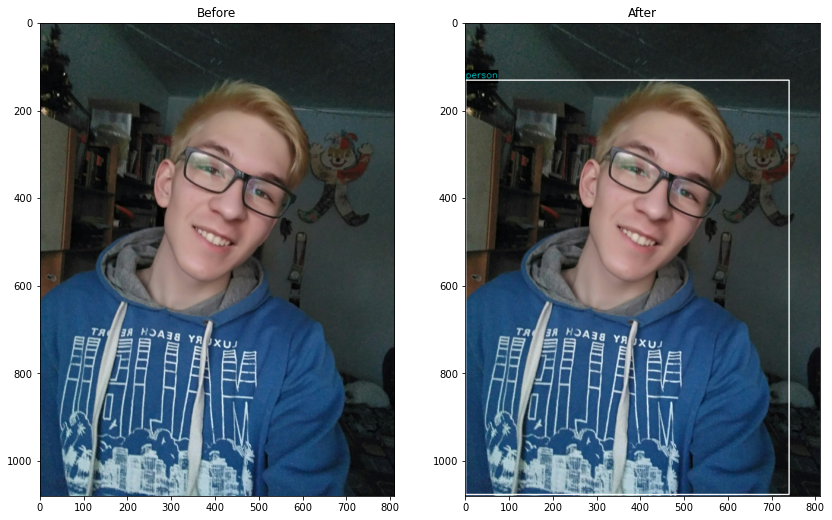

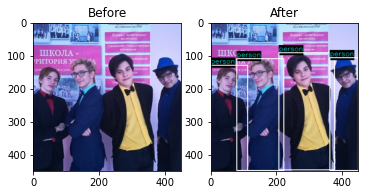

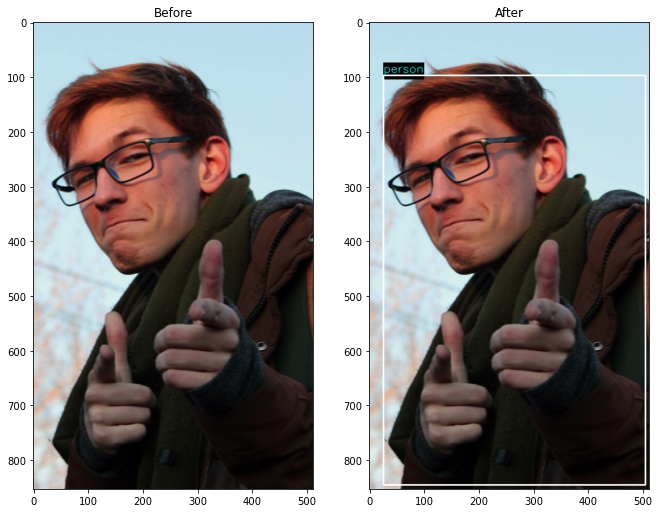

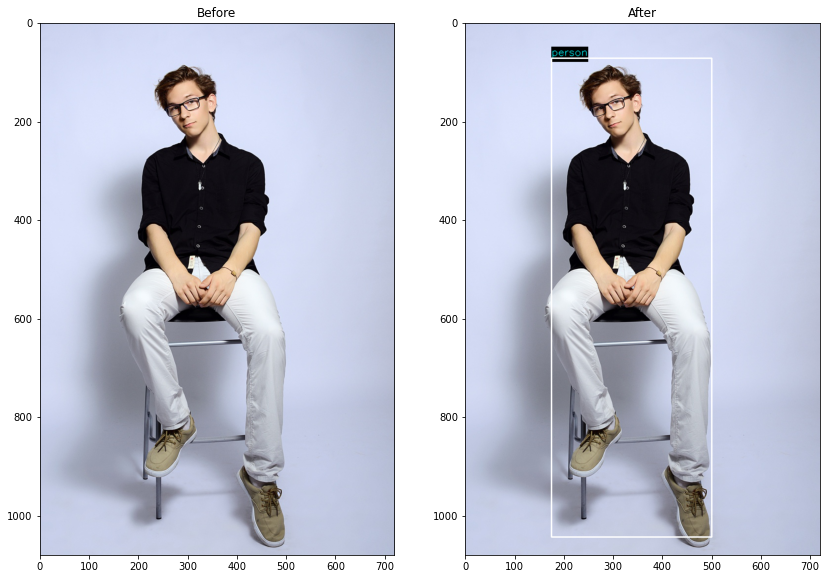

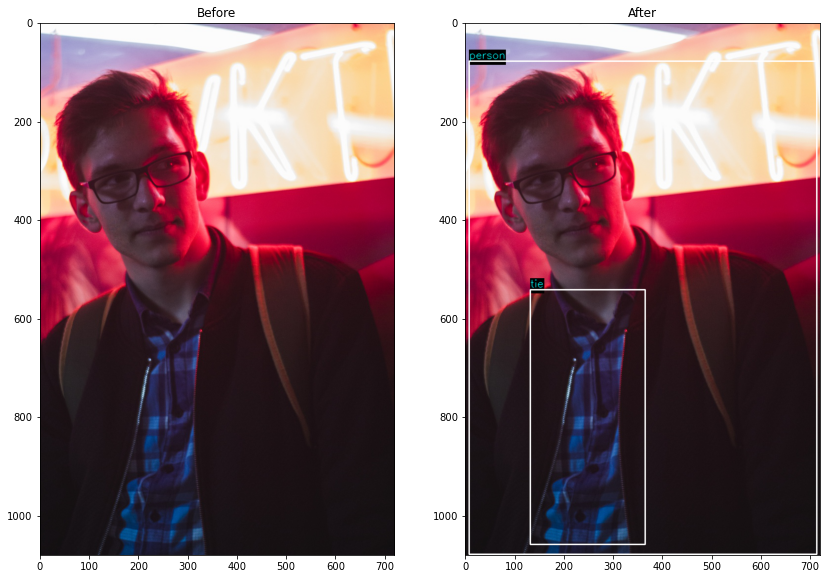

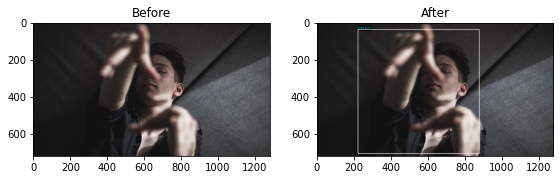

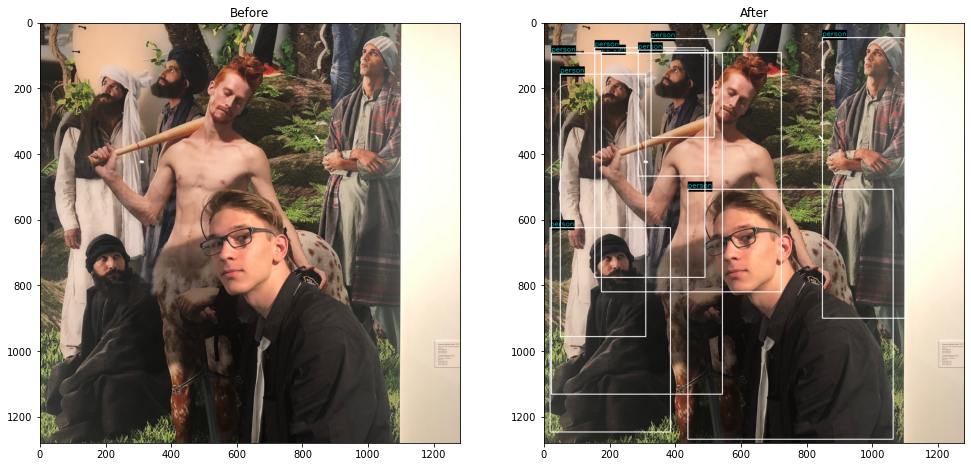

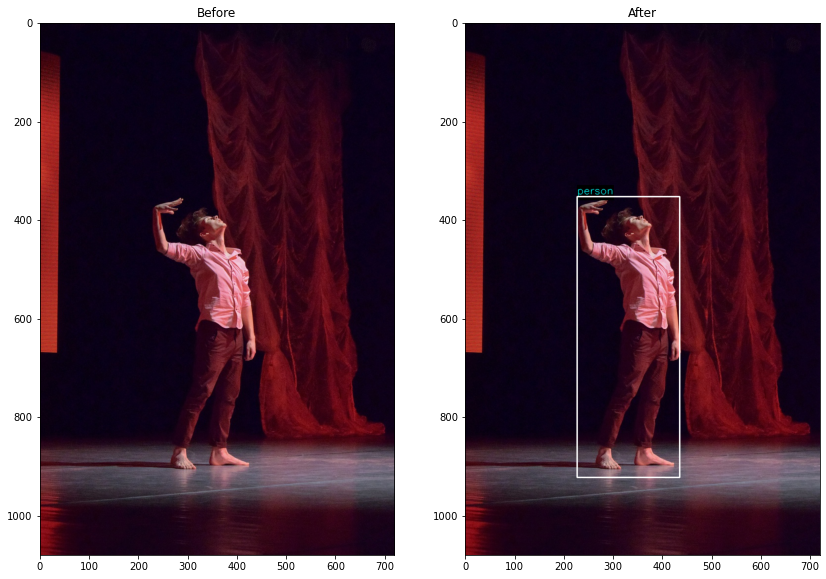

In [29]:
if not profile_is_closed:
    for i in range(pics_to_load):
        im = io.imread(pics[i])
        
        # print(objects_score)
        if len(im.shape)==3:
            if im.shape[-1]%3==0:
                plt.figure(figsize=[im.shape[0]/50,im.shape[1]/50]) 
                plt.subplot(131),plt.imshow(im),  plt.title("Before")
                objects = detect_objects(net, im)
                display_objects(im, objects)
                # print(objects_score)
else:
    print('Вероятно профиль закрыт, не удалось выполнить обработку')


In [30]:
if not profile_is_closed:
    import operator
    sorted_x = sorted(objects_score.items(), key=operator.itemgetter(1))
    # print(sorted_x)
    print( "3 самые частые категории: ",sorted_x[:-4:-1])

3 самые частые категории:  [('person', 35), ('tie', 3), ('book', 2)]
